In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from src.CPQAOA import CP_QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       qubo_cost,
                       partitioned_averages)

In [2]:
# Number of Qubits 
N=8
# number of excitations
k=4
# RNG seed for reproducibility
seed=3
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=1
# Maximal number of iterations for classical solver
max_iter=50
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False
w_z_phase = True


my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1,0,1])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())

"""my_grid = Grid(Rows=3,Cols=3)
print(f' Qubit indices in grid: \n', my_grid.get_grid_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_grid.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_grid.get_NNN_indices())
init_strat = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
my_grid.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_grid.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_grid.get_initialization_indices())"""

# Deciding between grid and 1d chain topology
my_topology = my_chain

 Qubit indices in chain: 
 [0 1 2 3 4 5 6 7]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)]

 Initialization strategy is: 
 [0 1 0 1 0 1 0 1]

 Corresponding indices is: 
 [1, 3, 5, 7]


In [3]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")
print("Check that qubo min cost is same as portfolio min cost:")
print(qubo_min_cost, portfolio_subspace_min_cost)
print("Check that qubo max cost is at least portfolio max cost:")
print(qubo_max_cost, portfolio_subspace_max_cost)

# Generating instances of ansatz'
CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_gradient=True,
                 with_z_phase=w_z_phase)

Min. cost portfolio (constrained subspace): 7.154007134369837
Optimal portfolio state (constrained subspace) is: |11001100>
Min. cost QUBO: 7.154007134369849
Min. cost QUBO state is: |11001100>
Check that qubo min cost is same as portfolio min cost:
7.154007134369849 7.154007134369837
Check that qubo max cost is at least portfolio max cost:
172.88657814851118 18.10861331717169


In [4]:
# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
optimizer_method = available_methods[2]

# Generating callback function for plotting
CP_z_phase_costs = [] # Normalized costs
CP_z_phase_probs = [] # probability of optimal state
CP_z_phase_grad_norm = []
solver_costs=[]

def CP_z_phase_callback_function(x):
    _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_z_phase_probs.append(0)
    CP_z_phase_costs.append(_cost_)
    CP_z_phase_grad_norm.append(np.linalg.norm(CP_z_phase_ansatz.get_gradient(x)))
    

# Generating initial guess for rotation angles for CP_ansatz
np.random.seed(seed)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles = layers * len(my_topology.get_NNN_indices())
if w_z_phase:
    N_angles += N
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
print(f"CP+Z-PHASE: {len(CP_z_phase_theta_i)}")    

CP+Z-PHASE: 15


In [5]:
CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, 
                                      x0=CP_z_phase_theta_i,
                                          method='BFGS',
                                      options={'disp': False, 
                                               'maxiter': max_iter},
                                      callback=CP_z_phase_callback_function)
CP_z_phase_res

None tensor([-2.2327e+02+1.3925e-06j,  3.8569e-06-3.7625e-06j,
        -5.6643e-06+8.9486e-06j,  5.8613e-06-1.1319e+00j,
        -9.4962e-06+2.3590e-06j, -4.7876e-06-5.1280e-07j,
         2.5496e-06-8.3639e-01j,  5.6465e-06+5.3860e-06j,
         7.7186e-06+1.1939e-05j, -4.4533e-06+1.1963e+00j,
         1.3583e-06+4.0756e-06j,  3.5101e-06+5.4947e-06j,
         6.5776e-06-4.2098e-01j, -1.2333e-07-3.4738e-08j,
        -9.7732e-07-6.4658e-07j,  4.7255e-02+9.1547e-07j,
        -8.5874e-06-7.3873e-06j,  8.1439e-07-3.4437e-06j,
        -4.7608e-06-2.0016e-02j, -1.4576e-05-1.0183e-05j,
        -3.3358e-07-7.9632e-07j, -8.4623e-14+7.9306e-14j,
        -6.3733e-06-2.4788e-07j, -8.0377e-08+1.2410e-07j,
         4.5423e-06-1.0105e-02j, -7.6984e-07+6.4950e-06j,
         2.2599e-09-2.9029e-09j,  1.0353e-02-6.1804e-06j,
         2.4466e-06+1.0576e-06j, -3.7553e-10-8.6482e-10j,
        -8.8217e-03+4.7371e-08j,  1.7249e-06+1.1507e-06j,
        -9.0278e-06+5.6755e-07j,  4.4603e-07-5.2841e-02j,
         

AttributeError: 'NoneType' object has no attribute 'numpy'

0.0 0.999999999992384


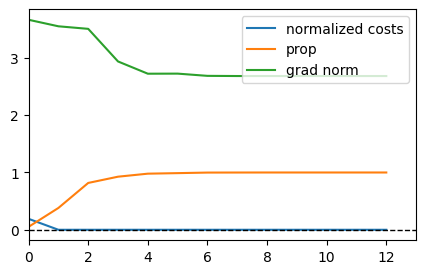

In [82]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_z_phase_costs))], CP_z_phase_costs, label='normalized costs')
ax.plot([it for it in range(len(CP_z_phase_probs))], CP_z_phase_probs, label='prop')
ax.plot([it for it in range(len(CP_z_phase_grad_norm))], CP_z_phase_grad_norm, label='grad norm')

ax.set_xlim(0,len(CP_z_phase_costs))
ax.hlines(0,0,len(CP_z_phase_costs),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
print(CP_z_phase_costs[-1],CP_z_phase_probs[-1])
plt.show()

In [44]:
CP_z_phase_grad_norm

[1.200974298573553,
 0.2829269398967131,
 0.2516082905468662,
 0.2544974419215008,
 0.035613185075376405,
 0.005969668927284142,
 0.000680626308575656,
 3.902250682353481e-05,
 1.2952713404239054e-06]

In [45]:
theta_opt = CP_z_phase_res.x
print(theta_opt)

[-2.11309819e-07  3.14159428e+00 -6.28318575e+00 -1.57079646e+00
 -4.42659654e+00]


In [38]:
THETAS = list(theta_opt)
eps = 1e-6
counter = 1
facs = [float(i) for i in range(1,30)]
saved = []
for angle in THETAS:
    angle_is_pi = False
    for multiplicative_factor in facs:
        for divisor in facs:
            if np.abs(multiplicative_factor*np.pi/divisor-angle) <= eps and angle not in saved:
                print(f'theta_{counter}: {angle} is approx.: {int(multiplicative_factor)}*pi/{int(divisor)}')     
                counter += 1
                saved.append(angle)
                angle_is_pi = True
            elif np.abs(-multiplicative_factor*np.pi/divisor-angle) <= eps and angle not in saved:
                print(f'theta_{counter}: {angle} is approx.: -{int(multiplicative_factor)}*pi/{int(divisor)}')     
                counter += 1
                saved.append(angle)
                angle_is_pi = True
    if not angle_is_pi:
        counter +=1

theta_2: 3.1415923163639228 is approx.: 1*pi/1
theta_3: 1.570796276673 is approx.: 1*pi/2
theta_5: -1.5707961955687195 is approx.: -1*pi/2


In [10]:
# Generating instances of ansatz'
CP_test_ansatz= CP_QAOA(N_qubits=N,
                        cardinality=k,
                        layers=layers,
                        topology=my_topology,
                        QUBO_matrix=Q,
                        with_next_nearest_neighbors=True,
                        with_gradient=True,
                        with_z_phase=False)

In [14]:
rand_theta = np.random.uniform(-4*np.pi,4*np.pi, 13)

In [15]:
# populating things
_ = CP_test_ansatz.get_cost(angles=rand_theta)

In [16]:
np.linalg.norm(CP_test_ansatz.get_gradient(angles=rand_theta))

3.5410316590416966

In [24]:
print(np.array(CP_test_ansatz.get_gradient(angles=rand_theta)).flatten())

[-0.15519875 -0.24269118  0.34079508  1.52934397 -0.78011851  0.34553458
 -2.57701937  0.10282884  0.51810679 -0.24581866  1.27521791  0.70154648
 -0.41724574]
